In [1]:
%%time

# --- Install offline packages ---
try:
    import ace_tools_open
except ModuleNotFoundError:
    print('Installing ace tools...')
    !pip install -q /kaggle/input/offline-packages/itables-2.3.0-py3-none-any.whl
    !pip install -q /kaggle/input/offline-packages/ace_tools_open-0.1.0-py3-none-any.whl

try:
    import timm
except ModuleNotFoundError:
    print('Installing timm...')
    !pip install -q /kaggle/input/offline-packages/timm-1.0.15-py3-none-any.whl

# --- Core libraries ---
import os
import math
import random
import time
import tempfile
import numpy as np

# --- Data handling ---
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from dataclasses import dataclass, field
from collections import defaultdict

# --- PyTorch ---
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

# --- Audio processing and torchaudio---
import torchaudio
import torchaudio.transforms as T
from torchaudio.functional import bandpass_biquad
from IPython.display import Audio, display

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import ace_tools_open as tools

# --- Parallel and Custom Tools ---
from joblib import Parallel, delayed
from torch.amp import GradScaler, autocast
from concurrent.futures import ProcessPoolExecutor, as_completed
from typing import Optional, List, Tuple, Dict
import timm
import gc

Installing ace tools...
CPU times: user 7.62 s, sys: 2.12 s, total: 9.73 s
Wall time: 20 s


## Configuration parameters

In [2]:
@dataclass
class CFG:
    # General
    seed: int = 315
    debug: bool = False
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    print_freq: int = 100
    num_workers: int = 4
    OUTPUT_DIR: str = '/kaggle/working/'
    temporary_dir: str = field(init=False)
    spectrogram_dir: str = field(init=False)
    METADATA_path: str = "spec_metadata.csv"

    ## Data paths ##
    # Base path to dataset
    data_path: str = '/kaggle/input/birdclef-2025/'
    # Key file paths
    metadata_path: str = field(init=False)
    taxonomy_path: str = field(init=False)
    sample_submission_path: str = field(init=False)
    location_path: str = field(init=False)
    # Audio data directories
    train_data_path: str = field(init=False)
    test_soundscapes_path: str = field(init=False)
    unlabeled_soundscapes_path: str = field(init=False)

    # Audio config
    topDB: int = 80
    FS: int = 32000
    CHUNK_LENGTH: float = 5.0   # seconds
    N_FFT: int = 1024
    HOP_LENGTH: int = 512  # 64
    N_MELS: int = 128 # tf_efficientnetv2_s.in21k_ft_in1k

    FMIN: int = 50
    FMAX: int = 14000
    POWER: int = 2
    SPEC_DTYPE: str = 'float16'  # for disk saving
    
    # VAD and Filtering
    VAD_ENABLED: bool = True  # Whether to apply Voice Activity Detection
    VAD_THRESHOLD: float = 0.4  # Confidence threshold for Silero VAD
    BANDPASS_LOW: int = 300
    BANDPASS_HIGH: int = 16000
    VISUALIZE_SKIPPED: bool = False  # Set to True to see spectrograms of skipped chunks

    # Silence detection settings
    window_size: int = 512             # Small window size to evaluate silence
    silence_threshold: float = 5e-4      # RMS threshold for silence (lower means stricter)
    silent_duration_ratio: float = 0.80  # 75% of the chunk must be silent to discard

    # Training
    BATCH_SIZE: int = 32
    EPOCHS: int = 5
    criterion: str = 'BCEWithLogitsLoss'
    optimizer: str = 'AdamW'
    LEARNING_RATE: float = 1e-3
    weight_decay: float = 1e-5
    scheduler: str = 'CosineAnnealingLR'
    min_lr: float = 1e-6
    n_fold: int = 5

    # Augmentation
    augment = True
    aug_prob: float = 0.5
    mixup_alpha: float = 0.4

    # Model
    model_name: str = "efficientnet_b0" # 'efficientnet_b3_pruned', 'efficientnetv2_rw_m', 'efficientvit_l1', 'efficientvit_l2', 'efficientvit_m0'
    pretrained: bool = False
    in_channels: int = 1
    input_directory: str = '/kaggle/input'
    input_model_filename: str = field(init=False)
    output_model_filename: str = field(init=False)
    pretrained_model_weights: str = field(init=False)
    sed_model_weights_path: str = field(init=False)

    def __post_init__(self):
        self.metadata_path = os.path.join(self.data_path, 'train.csv')
        self.taxonomy_path = os.path.join(self.data_path, 'taxonomy.csv')
        self.sample_submission_path = os.path.join(self.data_path, 'sample_submission.csv')
        self.location_path = os.path.join(self.data_path, 'recording_location.txt')
        self.train_data_path = os.path.join(self.data_path, 'train_audio')
        self.test_soundscapes_path = os.path.join(self.data_path, 'test_soundscapes')
        self.unlabeled_soundscapes_path = os.path.join(self.data_path, 'train_soundscapes')
        
        self.input_model_filename = f'{self.model_name}_pretrained.pth'
        self.output_model_filename = f'{self.model_name}_sed.pth'
        self.pretrained_model_weights = os.path.join(self.input_directory, "offline-packages", self.input_model_filename)
        self.sed_model_weights_path = os.path.join(self.input_directory, "effnet14", self.output_model_filename)
        self.num_classes = len(pd.read_csv(self.taxonomy_path))

        
        self.temporary_dir = tempfile.TemporaryDirectory().name
        self.spectrogram_dir = os.path.join(self.OUTPUT_DIR, 'precomputed_spectrograms')
        if self.debug:
            self.EPOCHS = 2
            print("⚠️ Debug mode is ON. Training only for 2 epochs.")

cfg = CFG()

In [3]:
def set_seed(seed=69):
    """
    Set seed for reproducibility
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(cfg.seed)

### Load Metadata

In [4]:
# Load training metadata
train_df = pd.read_csv(cfg.metadata_path)
print("Train CSV shape:", train_df.shape)
print(train_df.head(10))

Train CSV shape: (28564, 13)
  primary_label              secondary_labels                    type  \
0       1139490                          ['']                    ['']   
1       1139490                          ['']                    ['']   
2       1192948                          ['']                    ['']   
3       1192948                          ['']                    ['']   
4       1192948                          ['']                    ['']   
5       1192948                          ['']                    ['']   
6       1194042                          ['']                    ['']   
7       1194042                          ['']                    ['']   
8       1194042                          ['']                    ['']   
9        126247  ['65448', '22976', '476538']  ['advertisement call']   

               filename collection  rating  \
0  1139490/CSA36385.ogg        CSA     0.0   
1  1139490/CSA36389.ogg        CSA     0.0   
2  1192948/CSA36358.ogg      

In [5]:
# Load taxonomy info
taxonomy_df = pd.read_csv(cfg.taxonomy_path)
print("\nTaxonomy CSV shape:", taxonomy_df.shape)
print(taxonomy_df.head(1))


Taxonomy CSV shape: (206, 5)
  primary_label  inat_taxon_id       scientific_name           common_name  \
0       1139490        1139490  Ragoniella pulchella  Ragoniella pulchella   

  class_name  
0    Insecta  


In [6]:
def filter_data(
    df, 
    collection=None, 
    rating=None, 
    primary_label=None, 
    common_name=None, 
    filename=None,
    random_sample=True
):
    # Step 1: Filter the dataframe
    filtered = df.copy()
    
    if collection:
        filtered = filtered[filtered['collection'] == collection]
    if rating is not None:
        filtered = filtered[filtered['rating'] == rating]
    if primary_label:
        filtered = filtered[filtered['primary_label'] == primary_label]
    if filename:
        filtered = filtered[filtered['filename'] == filename]
    if common_name:
        filtered = filtered[filtered['common_name'].str.contains(common_name, case=False, na=False)]

    # Step 2: Select sample
    if filtered.empty:
        print("No matches found with the given filters.")
        return

    return filtered  # return metadata for inspection


def play_audio(audio_dir, row):
    #sample = filtered.sample(1) if random_sample else filtered.iloc[[0]]
    #row = sample.iloc[0]
    
    # Step 3: Load and play
    path = os.path.join(audio_dir, row['filename'])
    print(f"▶️ Playing: {row['common_name']} [{row['primary_label']}]")
    print(f"Collection: {row['collection']}, Rating: {row['rating']}")
    print(f"File: {row['filename']}")
    display(Audio(path))
    

# --- Visualization and Inspection ---
def visualize_spectrogram(path, title="Spectrogram"):
    """
    Visualize a saved spectrogram from .npy
    """
    print(f"[INFO] Visualizing spectrogram: {path}")
    spectrogram = np.load(path)
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram, aspect='auto', origin='lower')
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar(label="Log-Mel Power (dB)")
    plt.tight_layout()
    plt.show()


def inspect_chunks(metadata, precompute_dir):
    """
    Display chunks and analyze voice presence.
    """
    for chunk_name, primary_label in metadata:
        
        chunk_path = os.path.join(precompute_dir, chunk_name)
        print(f"[INFO] Inspecting chunk: {chunk_name}")
        print(f"[INFO] Primary label: {primary_label}")
        if os.path.exists(chunk_path):
            visualize_spectrogram(chunk_path, title=chunk_name)
        else:
            print(f"[WARNING] File not found: {chunk_path}")

In [7]:
# Mock of global stats based on metadata
def compute_species_stats(metadata_df):
    stats = {str(l): {"total_count": 0, "CSA": 0, "iNat":0, "XC":0, "class_name":c} for l, c in zip(taxonomy_df["primary_label"], taxonomy_df["class_name"])}
    
    for _, row in metadata_df.iterrows():
        species = row["primary_label"]
        collection = row["collection"]
        stats[species]["total_count"] += 1
        stats[species][collection] += 1
    
    return stats

species_stats = compute_species_stats(train_df)

# Display for user
tools.display_dataframe_to_user(name="Species Stats Sample", dataframe=pd.DataFrame([
    {"species": sp, "class_name":d["class_name"], "total_count": d["total_count"],  "CSA": d["CSA"], "iNat":d["iNat"], "XC":d["XC"]}
    for sp, d in species_stats.items()
]))


Species Stats Sample


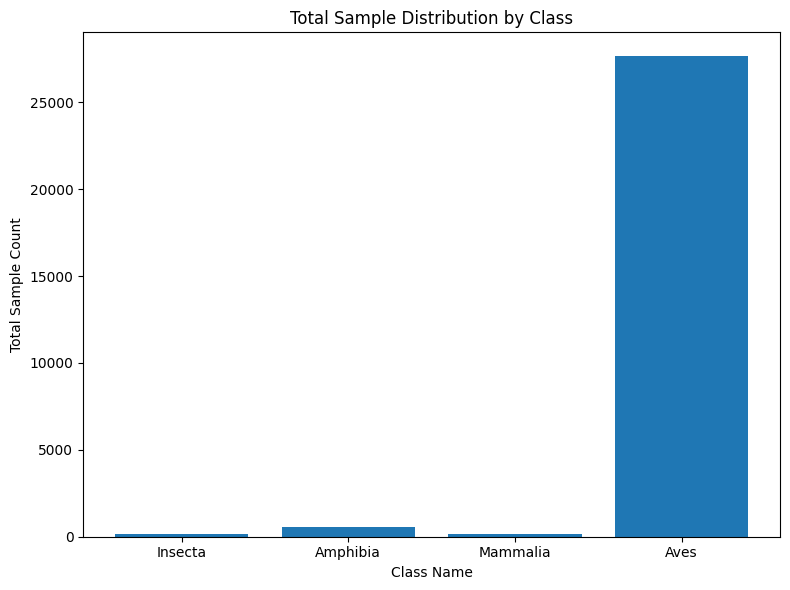

In [8]:
# Aggregate counts by class_name
class_counts = {}
for species, stats in species_stats.items():
    cls = stats["class_name"]
    class_counts[cls] = class_counts.get(cls, 0) + stats["total_count"]

# Plot
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class Name')
plt.ylabel('Total Sample Count')
plt.title('Total Sample Distribution by Class')
plt.tight_layout()
plt.show()

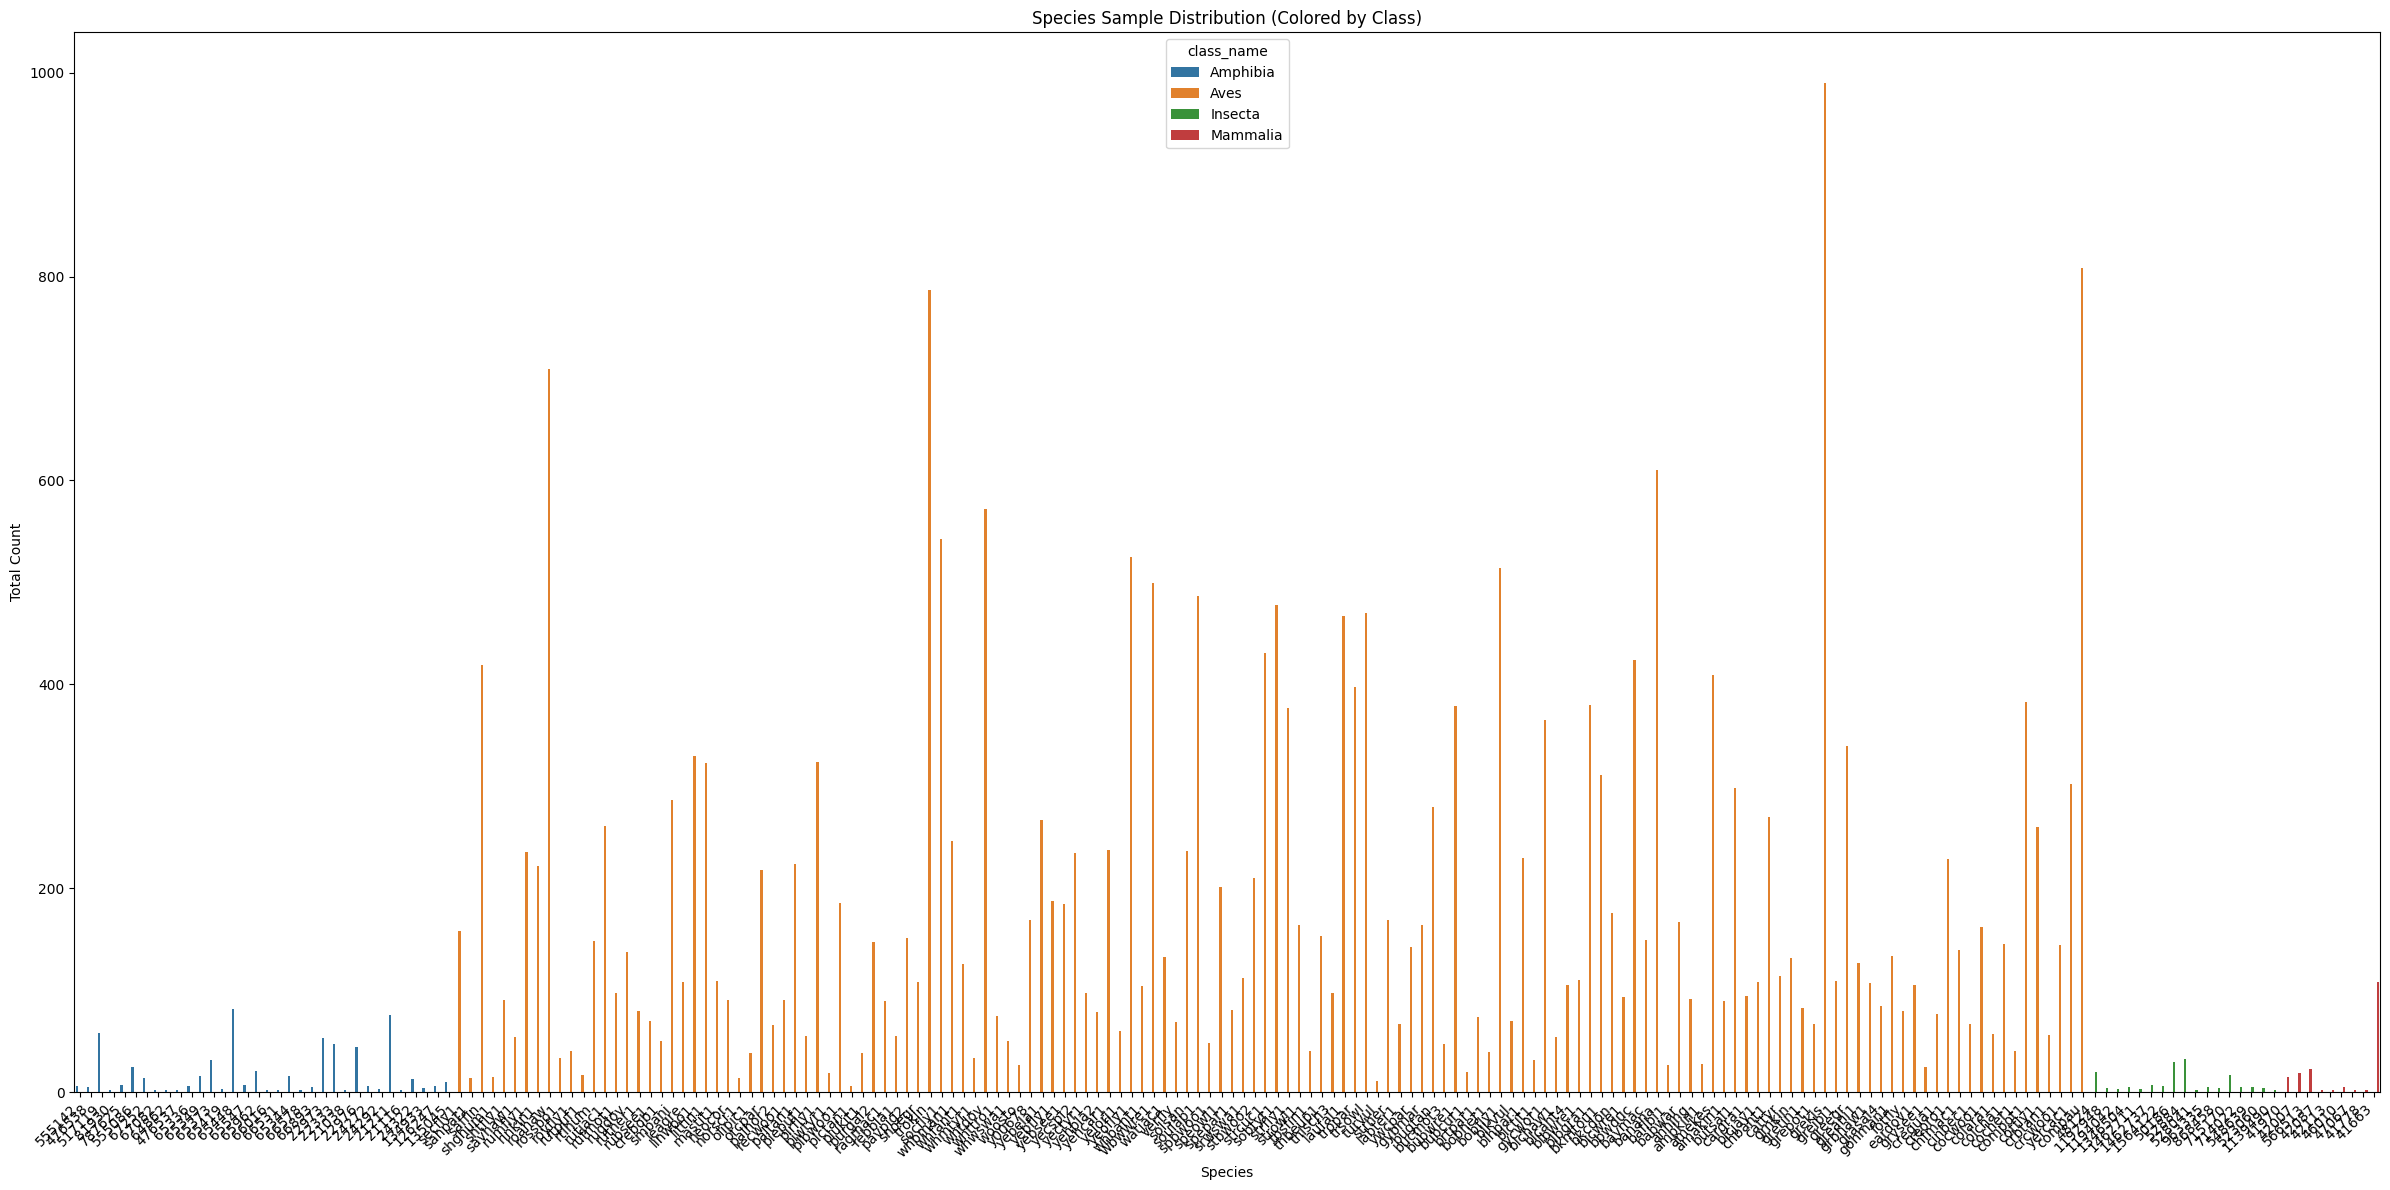

In [9]:
# Prepare DataFrame
data = pd.DataFrame({
    "species": list(species_stats.keys()),
    "total_count": [species_stats[k]["total_count"] for k in species_stats.keys()],
    "class_name": [species_stats[k]["class_name"] for k in species_stats.keys()]
})
# Sort by class_name
data = data.sort_values(by="class_name")
# Plot with seaborn
plt.figure(figsize=(24, 12))
sns.barplot(x="species", y="total_count", hue="class_name", data=data)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Species')
plt.ylabel('Total Count')
plt.title('Species Sample Distribution (Colored by Class)')
plt.tight_layout()
plt.show()

In [10]:
class ChunkStatsTracker:
    """
    Tracks per-species and per-collection chunk statistics during preprocessing.
    Stores per-chunk scores (e.g., RMS, model confidence).
    """

    def __init__(self):
        self.class_chunk_counts = defaultdict(int)
        self.class_chunk_scores = defaultdict(list)
        self.collection_counts = defaultdict(int)
        self.chunk_metadata = []

    def log_chunk(self, species_id, collection, score, rms, filename):
        self.class_chunk_counts[species_id] += 1
        self.class_chunk_scores[species_id].append(score)
        self.collection_counts[collection] += 1
        self.chunk_metadata.append({
            "species": species_id,
            "collection": collection,
            "score": score,
            "rms": rms,
            "filename": filename
        })

    def get_summary_dataframe(self):
        return pd.DataFrame(self.chunk_metadata)

    def save_to_csv(self, path):
        df = self.get_summary_dataframe()
        os.makedirs(os.path.dirname(path), exist_ok=True)
        df.to_csv(path, index=False)

    def get_species_stats(self):
        return {
            species: {
                "count": self.class_chunk_counts[species],
                "avg_score": sum(self.class_chunk_scores[species]) / len(self.class_chunk_scores[species])
            }
            for species in self.class_chunk_counts
        }

    def print_top_species(self, top_k=10):
        stats = self.get_species_stats()
        sorted_stats = sorted(stats.items(), key=lambda x: -x[1]["count"])
        print(f"\nTop {top_k} species by chunk count:")
        for species, s in sorted_stats[:top_k]:
            print(f"  {species:12} | count: {s['count']:4d} | avg_score: {s['avg_score']:.3f}")
        print()

    def print_collection_distribution(self):
        print("\nChunk count per collection:")
        for c, count in self.collection_counts.items():
            print(f"  {c:6}: {count}")
        print()

tracker = ChunkStatsTracker()
tracker.log_chunk(species_id="sp1", collection="XC", score=0.88, rms=0.035, filename="file1")
tracker.log_chunk(species_id="sp1", collection="XC", score=0.70, rms=0.030, filename="file2")
tracker.log_chunk(species_id="sp2", collection="CSA", score=0.92, rms=0.040, filename="file3")

tracker.print_top_species()
tracker.print_collection_distribution()



Top 10 species by chunk count:
  sp1          | count:    2 | avg_score: 0.790
  sp2          | count:    1 | avg_score: 0.920


Chunk count per collection:
  XC    : 2
  CSA   : 1



In [11]:
class EfficientNetSED(nn.Module):
    """
    EfficientNet with a custom SED head for frequency-wise attention.
    
    This model:
    - Uses a pretrained EfficientNet backbone
    - Applies a frequency-wise attention mechanism
    - Outputs class probabilities for multi-class classification
    
    Arguments:
    ----------
    cfg : object
        Configuration object (assumes it's an instance of CFG)
    """
    def __init__(self, cfg):
        super().__init__()
        
        # Store config and device
        self.cfg = cfg
        self.device = torch.device(cfg.device)

        # Create model with the correct architecture
        self.backbone = timm.create_model(cfg.model_name, pretrained=cfg.pretrained)

        # Load weights manually
        checkpoint_path = cfg.pretrained_model_weights
        if checkpoint_path:
            print(f"[INFO] Loading weights from {checkpoint_path}")
            state_dict = torch.load(checkpoint_path, map_location=self.device, weights_only=True)
            if "model" in state_dict:
                state_dict = state_dict["model"]  # In case it's wrapped in 'model' key
            self.backbone.load_state_dict(state_dict)

        # Remove classifier head, we will add our own
        self.feature_dim = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Identity()  # Remove classifier

        # Frequency-wise attention block -> attention mechanism to emphasize important frequency regions.
        self.att_block = nn.Sequential(
            nn.AdaptiveAvgPool2d((None, 1)),          # Mean over frequency bands
            nn.Conv2d(self.feature_dim, self.feature_dim, kernel_size=1),
            nn.Sigmoid()
        )

        # Custom classifier head
        self.classifier = nn.Sequential(
            nn.Conv2d(self.feature_dim, cfg.num_classes, kernel_size=1),
            nn.AdaptiveMaxPool2d((1, 1)),
            nn.Flatten()
        )

    def forward(self, x):
        """
        Forward pass of the model.
        
        Parameters:
        -----------
        x : torch.Tensor
            Input tensor of shape [B, 3, M, T], where:
            - B = Batch size
            - M = Mel bands (frequency bins)
            - T = Time frames

        Returns:
        --------
        torch.Tensor:
            Output tensor of shape [B, num_classes]
        """
        x = x.to(self.device)
        features = self.backbone.forward_features(x)  # EfficientNet backbone [B, C, M', T']
        attn = self.att_block(features)  # Attention on frequency bands [B, C, T', 1]
        features = features * attn       # Apply attention
        
        out = self.classifier(features)  # Classify [B, num_classes]
        return out


def model_predict_fn(spec_tensor: torch.Tensor) -> torch.Tensor:
    """
    Runs inference on a single spectrogram and returns per-class probabilities.
    Expects input shape [1, 3, M, T].
    """
    model.eval()
    with torch.no_grad(), autocast(device_type=cfg.device):
        outputs = model(spec_tensor.to(cfg.device))
        probs = torch.sigmoid(outputs)
    return probs.squeeze(0).cpu()
    
# === Load your trained model ===
model = EfficientNetSED(cfg)
print(f"[INFO] Loading weights from {cfg.sed_model_weights_path}")
model.load_state_dict(torch.load(cfg.sed_model_weights_path, map_location=cfg.device))


[INFO] Loading weights from /kaggle/input/offline-packages/efficientnet_b0_pretrained.pth
[INFO] Loading weights from /kaggle/input/effnet14/efficientnet_b0_sed.pth


<All keys matched successfully>

In [12]:
# Global variable for the VAD model (accessible in each worker)
global_vad_model = None
global_get_speech_timestamps = None
global_read_audio = None

def initialize_vad_model():
    """
    Initializes the VAD model and assigns it to the global scope.
    This runs once per process.
    """
    global global_vad_model, global_get_speech_timestamps
    torch.set_num_threads(1)  # Avoid PyTorch oversubscription

    # Load the model
    global_vad_model, (global_get_speech_timestamps, _, global_read_audio, _, _) = torch.hub.load(
        repo_or_dir='snakers4/silero-vad', 
        model='silero_vad',
        trust_repo=True
    )
    print("[INFO] Silero VAD model loaded successfully in worker process.")

class SpectrogramPreprocessor:
    """
    Converts audio files into log-mel spectrograms and saves them as .npy files.
    
    Supports:
    - Silero VAD for speech detection (via torch.hub)
    - 5-second chunking
    - Band-pass filtering
    - Parallel processing

    Methods:
    --------
    process_file(filename) → Optional[List[Tuple[str, int]]]
        Process, chunk, and save spectrograms from a single audio file.
    preprocess_all_files(file_list) → List[Tuple[str, int]]
        Preprocess all files in parallel.
    """

    def __init__(self, cfg, full_metadata: pd.DataFrame, species_stats, model_predict_fn, chunk_tracker, collection_sample_strategy, num_workers = None):
        self.cfg = cfg
        self.metadata = full_metadata
        self.sample_rate = cfg.FS
        self.chunk_len = int(cfg.CHUNK_LENGTH * cfg.FS)
        self.output_dir = cfg.spectrogram_dir
        os.makedirs(self.output_dir, exist_ok=True)

        # Torchaudio transforms
        self.mel_transform = T.MelSpectrogram(
            sample_rate=cfg.FS,
            n_fft=cfg.N_FFT,
            hop_length=cfg.HOP_LENGTH,
            n_mels=cfg.N_MELS,
            f_min=cfg.FMIN,
            f_max=cfg.FMAX,
            power=cfg.POWER
        )
        self.db_transform = T.AmplitudeToDB(top_db=cfg.topDB)

        self.class_weights = {"Insecta" : 5,
                "Aves" : 0.5,
                "Amphibia": 4,
                "Mammalia": 5}

        # Collection-specific sampling logic
        self.species_stats = species_stats
        self.max_count = max(species_stats[k]["total_count"] for k in list(species_stats.keys()))
        self.collection_sample_strategy = collection_sample_strategy

        # Statistics trackers
        self.chunk_counter = {}
        self.model_predict_fn = model_predict_fn  # Function to get model confidence on chunk
        self.tracker = chunk_tracker  # ChunkStatsTracker instance

        num_workers = num_workers if num_workers is not None else cfg.num_workers
        self.vad_threshold = {"CSA": 0.35,
                             "iNat": 0.6,
                             "XC": 0.8}
        if cfg.VAD_ENABLED and num_workers == 1:
            initialize_vad_model()

    def preprocess_all_files(self, file_list: List[str],) -> List[Tuple[str, int]]:
        """
        Runs preprocessing for all files in parallel.

        Parameters:
        -----------
        file_list : List[str]
            List of filenames to process.

        Returns:
        --------
        List of tuples (chunk_filename, num_frames).
        """
        print(f"[INFO] Parallel processing {len(file_list)} files...")
        
        if self.cfg.VAD_ENABLED:
            print(f"[INFO] Voice Activity Detection enabled, filtering human voice and silence...")
            results = self.run_in_parallel_with_VAD_enabled(file_list)
        else:
            print(f"[INFO] Voice Activity Detection NOT enabled, no filtering...")
            results = self.run_in_parallel_no_VAD(file_list)
        
        print("[INFO] Pre-processing complete!")
        results_df = self._create_and_save_csv(results)
        self.track()
        return results_df

    def run_in_parallel_with_VAD_enabled(self, file_list: List[str]) -> List[Tuple[str, int]]:
         # Use ProcessPoolExecutor with initializer
        results = []
        with ProcessPoolExecutor(max_workers=self.cfg.num_workers, initializer=initialize_vad_model) as executor:
            # Submit all tasks
            futures = {executor.submit(self.process_file, i, f): f for i, f in tqdm(file_list, total=len(file_list), desc="Pre-computing spectrograms")}
    
            # Collect results
            for future in tqdm(as_completed(futures), total=len(futures), desc="Collecting results"):
                try:
                    result = future.result()
                    if result is not None:
                        results.extend(result)
                except Exception as e:
                    print(f"[ERROR] Exception in worker process: {e}")
        return results

    def run_in_parallel_no_VAD(self, file_list: List[str]) -> List[Tuple[str, int]]:
        results = Parallel(n_jobs=self.cfg.num_workers)(
            delayed(self.process_file)(i, f) for i, f in tqdm(file_list, desc="Pre-computing Spectrograms")
        )
        
        # Flatten the list of lists
        return [item for sublist in results if sublist is not None for item in sublist]

    def process_file(self, index: int, filename: str) -> Optional[List[Tuple[str, int]]]:
        """
        Preprocess an audio file into multiple 5-second log-mel spectrograms.
        
        Parameters:
        -----------
        filename : str
            Path to the audio file relative to the training directory.

        Returns:
        --------
        list of tuples or None:
            [(chunk_filename, num_frames), ...] if successful, else None.
        """
        file_path = os.path.join(self.cfg.train_data_path, filename)
        rating = self.metadata.iloc[index]["rating"]
        collection = self.metadata.iloc[index]["collection"] # self.get_collection(filename)
        species_id = filename.split("/")[0]
        if self.cfg.debug:
            print(filename)
        try:
            # Load the waveform and split into 5-second chunks
            waveform, wav_16000 = self._load_waveforms_32k_16k(file_path)
            chunks_16000 = self._split_into_chunks(wav_16000, 16000)
            
            # Remove voice and silence
            indices = []
            for i, c_16 in chunks_16000.items():
                if self.cfg.debug:
                    real_idx = float(i)
                    print(f"Chunk that goes from: {real_idx*5} to {real_idx*5+5}:")
                # Apply VAD only if enabled
                if self.cfg.VAD_ENABLED:
                    if self._contains_human_voice(c_16, collection = collection):
                        if self.cfg.VISUALIZE_SKIPPED:
                            self._visualize_spectrogram(c_16, title=f"Skipped Chunk from: {real_idx*5} to {real_idx*5+5}")
                        indices.append(i)  # Skip chunks with human voice
            chunks = self._split_into_chunks(waveform, 32000)
            n = len(chunks)
            for i in indices:
                del chunks[i]
            if collection == "XC":
                keep_n = self.collection_sample_strategy[collection](rating, self.species_stats[species_id]['total_count'], self.species_stats[species_id]['class_name'], self.max_count, self.class_weights)
                chunks = self.select_top_chunks(chunks, n, keep_n)
            elif collection == "iNat":
                keep_n = self.collection_sample_strategy[collection](self.species_stats[species_id]['total_count'], self.species_stats[species_id]['class_name'], self.max_count, self.class_weights)
                chunks = self.select_top_chunks(chunks, n, keep_n)
            elif collection == "CSA":
                keep_n = self.collection_sample_strategy[collection](self.species_stats[species_id]['total_count'], self.species_stats[species_id]['class_name'], self.max_count, self.class_weights)
                chunks = self.select_top_chunks(chunks, n, keep_n)

            if self.cfg.debug:
                print("Should be: ", keep_n, "chunks")
            # Initialize list for processed data
            processed = []
            # Loop through the selected chunks and save spectrograms            
            for real_idx, chunk in chunks.items():
                real_idx = float(real_idx)
                if self.cfg.debug:
                    print(f"Chunk that goes from: {real_idx*5} to {real_idx*5+5}:")
                spec = self._waveform_to_spec(chunk)
                i = int(real_idx*5)
                chunk_filename = f"{filename[:-4]}_chunk_{i}{'_5' if real_idx*5!=float(i) else ''}.npy"
                self._save_spectrogram(spec, chunk_filename)

                processed.append((chunk_filename, species_id))

                
                rms = self.compute_rms(chunk)
                conf = self.compute_confidence(spec)
                score = 0.5 * rms + 0.5 * conf
                self.tracker.log_chunk(species_id, collection, score, rms, chunk_filename)

            return processed
        except Exception as e:
            raise e
            if self.cfg.debug:
                print(f"[ERROR] Failed to process {filename}: {e}")
            return None
        
        
    def _load_waveforms_32k_16k(self, path: str) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Load audio, convert to mono, crop/pad to fixed length.

        Returns:
        --------
        waveform : Tensor [1, T]
        """
        wav_32000, sr = torchaudio.load(path)  # (channels, samples) = (2, 32000)
        if wav_32000.shape[0] > 1:
            # average the two channels and add a channel dimension back
            wav_32000 = wav_32000.mean(dim=0, keepdim=True)  # convert to mono

        # Bandpass filter for noise removal
        #waveform = bandpass_biquad(waveform, self.sample_rate, self.cfg.BANDPASS_LOW, self.cfg.BANDPASS_HIGH)
        # Truncate to max allowed duration
        #max_samples = self.sample_rate * self.cfg.AUDIO_MAX_LEN
        #waveform = waveform[..., :max_samples]
        ## 
        transform = torchaudio.transforms.Resample(orig_freq=sr,
                                                   new_freq=16000)
        wav_16000 = transform(wav_32000)

        return wav_32000, wav_16000

    def _waveform_to_spec(self, waveform: torch.Tensor) -> torch.Tensor:
        """
        Convert waveform to normalized log-mel spectrogram.
        
        Returns:
        --------
        spec : Tensor [M, T]
        """
        mel = self.mel_transform(waveform)
        log_mel = self.db_transform(mel)
        norm_spec = (log_mel - log_mel.mean()) / (log_mel.std() + 1e-6)
        return norm_spec.squeeze(0).cpu()  # shape [M, T]

    def _split_into_chunks(self, waveform: torch.Tensor, sr = 32000) -> List[torch.Tensor]:
        """
        Splits the waveform into 5-second chunks.
        
        Returns:
        --------
        list of Tensors:
            Each tensor represents 5 seconds of audio.
        """
        total_samples = waveform.shape[-1]
        chunk_len = int(self.cfg.CHUNK_LENGTH * sr)
        chunks = dict()
        for start in range(0, total_samples, chunk_len//2):
            end = start + chunk_len
            chunk = waveform[..., start:end]
            
            if self._should_pad_chunk(chunk, start, total_samples, chunk_len):
                # cyclic padding
                chunk = self.cyclic_pad(chunk, chunk_len)
                if self.cfg.debug:
                    print(f"[INFO] Padded chunk to {chunk_len} samples")
            elif chunk.shape[-1] < chunk_len:
                if self.cfg.debug:
                    print(f"[INFO] Skipping under-sized chunk: {chunk.shape[-1]} samples")
                continue
                
            chunks[str(start / chunk_len)] = chunk
        return chunks

    def _should_pad_chunk(self, chunk: torch.Tensor, start, total_samples: int, chunk_len) -> bool:
        """
        Determines if a chunk should be padded or discarded. If the audio is less than 5 seconds or if the last chunk (of an audio > 5s) is more than 2 seconds, then pad
        """
        remaining_samples = total_samples - start
        return (total_samples < chunk_len) or  ((chunk_len // 3) < remaining_samples < chunk_len)

    def cyclic_pad(self, chunk: torch.Tensor, desired_len: int) -> torch.Tensor:
        repeats = (desired_len // chunk.shape[-1]) + 1
        return chunk.repeat(1, repeats)[..., :desired_len]

    def select_top_chunks(self, chunks: Dict[int, torch.Tensor], n: int, keep_n: Optional[int]) -> List[torch.Tensor]:
        if keep_n is None or len(chunks) <= 5:
            return chunks
        rms_scores = [self.compute_rms(chunks[str(i/2)]) if chunks.get(str(i/2), None) is not None else 0 for i in range(n)]

        # Filter out zero-RMS chunks (zero score mean chunk has been removed during VAD)
        nonzero_rms = {idx: score for idx, score in enumerate(rms_scores) if score > 0}
        
        # Get 25th percentile threshold
        q25 = np.percentile(list(nonzero_rms.values()), 33)
    
        # Keep only chunks above 25% quantile
        filtered = {idx: score for idx, score in nonzero_rms.items() if score > q25}
        
        # Select top-N chunks
        top_indices = sorted(filtered, key=filtered.get, reverse=True)[:keep_n]
        selected_chunks = {str(idx/2): chunks[str(idx/2)] for idx in top_indices}
    
        if self.cfg.debug:
            print(f"[INFO] Selected top {min(keep_n, len(filtered))} chunks (indices): {top_indices}")
            print(f"[INFO] RMS scores: {sorted(rms_scores, reverse=True)}")
    
        return selected_chunks

    def compute_rms(self, chunk: torch.Tensor) -> float:
        return torch.sqrt(torch.mean(chunk**2)).item()

    def compute_confidence(self, spec: torch.Tensor) -> float:
        spec = spec.unsqueeze(0).repeat(1, 3, 1, 1)  # simulate batch and RGB
        with torch.no_grad():
            prob = self.model_predict_fn(spec.to(self.cfg.device))
        return prob.max().item()

        
    def _is_mostly_silent(self, chunk: torch.Tensor) -> bool:
        """
        Checks if the chunk is mostly silent (75% of its duration).
        
        Parameters:
        -----------
        chunk : torch.Tensor
            The waveform chunk to evaluate.

        Returns:
        --------
        bool:
            True if mostly silent, False otherwise.
        """
        # Compute RMS in small windows
        windows = chunk.unfold(1, self.cfg.window_size, self.cfg.window_size)
        rms = windows.pow(2).mean(dim=-1).sqrt()

        # Count how many windows are below the silence threshold
        num_silent_windows = (rms < self.cfg.silence_threshold).sum().item()
        total_windows = rms.size(1)

        # If the ratio of silent windows is greater than the threshold, it's mostly silent
        if num_silent_windows / total_windows >= self.cfg.silent_duration_ratio:
            return True
        return False

    def _contains_human_voice(self, chunk: torch.Tensor, collection) -> bool:
        """
        Detects if human voice is present in the chunk using Silero VAD.
        Uses the globally-initialized model in each worker.
        """
        
        # Check for silence
        if self._is_mostly_silent(chunk):
            if self.cfg.debug:
                print("[INFO] Skipped silent chunk.")
            return True
            
        if global_vad_model is None or global_get_speech_timestamps is None:
            raise ValueError("VAD Model not initialized in the worker process!")
        t = self.vad_threshold[collection]
        # wav = global_read_audio('path_to_audio_file')
        timestamps = global_get_speech_timestamps(chunk.numpy().flatten(), global_vad_model, return_seconds=True, threshold=t)
        
        if self.cfg.debug:
            print("Timestamps:", timestamps)
        return len(timestamps) > 0

    def _is_collection_csa(self, filename: str) -> bool:
        if 'CSA' in filename:
            return True
        return False

    def _is_collection_xc(self, filename: str) -> bool:
        if 'XC' in filename:
            return True
        return False

    def _save_spectrogram(self, spec: torch.Tensor, filename: str):
        """
        Save the spectrogram as a .npy file.

        Parameters:
        -----------
        spec : torch.Tensor
            The normalized spectrogram tensor [M, T]
        filename : str
            Original filename, used to derive save path
        """
        save_path = os.path.join(self.output_dir, filename)
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        np.save(save_path, spec.squeeze(0).numpy().astype(self.cfg.SPEC_DTYPE))

    def _create_and_save_csv(self, metadata):
        # Create a DataFrame from metadata
        spec_df = pd.DataFrame(metadata, columns=["filename", "primary_label"])
        
        # Display and save
        tools.display_dataframe_to_user(name="Spectrogram Metadata with Labels", dataframe=spec_df)
        spec_df.to_csv(os.path.join(cfg.OUTPUT_DIR, "spec_metadata.csv"), index=False)

    def track(self):
        self.tracker.print_top_species()
        self.tracker.print_collection_distribution()
        self.tracker.save_to_csv(os.path.join(cfg.OUTPUT_DIR, "chunk_stats.csv"))

    def _visualize_spectrogram(self, chunk, title="Spectrogram"):
        """
        Visualizes a spectrogram of a skipped chunk.
        """
        spec = self._waveform_to_spec(chunk)
        plt.figure(figsize=(10, 4))
        
        plt.imshow(spec.numpy(), aspect='auto', origin='lower')
        plt.title(title)
        plt.colorbar()
        plt.show()

# Collection-specific sampling logic
def sample_strategy_xc(rating_chunk, species_count, class_name, max_species_count, class_weights):
    """XC contains Aves(21040), Amphibia(147), Mammalia(17)"""
    class_weight = class_weights[class_name]
    species_weight = max(1, np.log(max_species_count / species_count)) # between 6 and 1
    rating_weight = 2 if rating_chunk >= 3 else 1 if rating_chunk > 2 else 0.5
    return round(class_weight*species_weight*rating_weight)
    

def sample_strategy_inat(species_count, class_name, max_species_count, class_weights):
    """iNat contains Aves(6608), Amphibia(429), Mammalia(161)"""
    class_weight = class_weights[class_name]
    species_weight = max(1, np.log(max_species_count / species_count)) # between 6 and 1
    return int(class_weight*species_weight*0.8)  # iNat usually lower quality, but no rating available

def sample_strategy_csa(species_count, class_name, max_species_count, class_weights):
    """XC contains Insecta(155), Amphibia(7)"""
    class_weight = class_weights[class_name]
    species_weight = max(1, np.log(max_species_count / species_count)) # between 6 and 1
    return int(class_weight*species_weight*0.75)   # CSA has very few examples


▶️ Playing: Turkey Vulture [turvul]
Collection: XC, Rating: 4.0
File: turvul/XC904279.ogg


Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master


[INFO] Silero VAD model loaded successfully in worker process.
[INFO] Total chunks processed: 4
[INFO] Inspecting chunk: turvul/XC904279_chunk_0.npy
[INFO] Primary label: turvul
[INFO] Visualizing spectrogram: /kaggle/working/precomputed_spectrograms/turvul/XC904279_chunk_0.npy


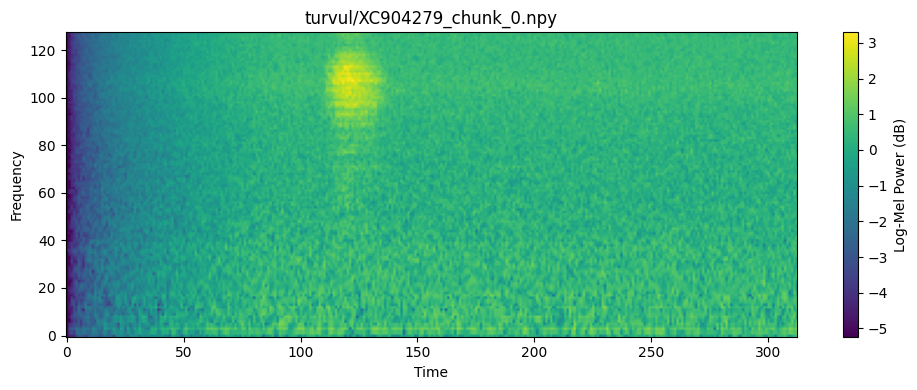

[INFO] Inspecting chunk: turvul/XC904279_chunk_12_5.npy
[INFO] Primary label: turvul
[INFO] Visualizing spectrogram: /kaggle/working/precomputed_spectrograms/turvul/XC904279_chunk_12_5.npy


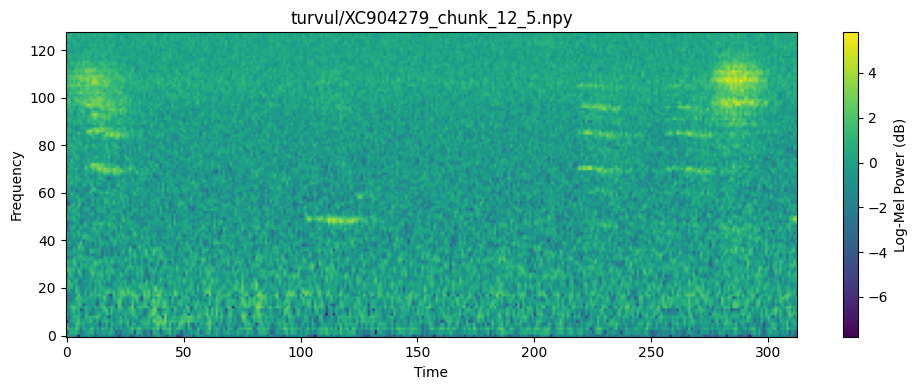

[INFO] Inspecting chunk: turvul/XC904279_chunk_7_5.npy
[INFO] Primary label: turvul
[INFO] Visualizing spectrogram: /kaggle/working/precomputed_spectrograms/turvul/XC904279_chunk_7_5.npy


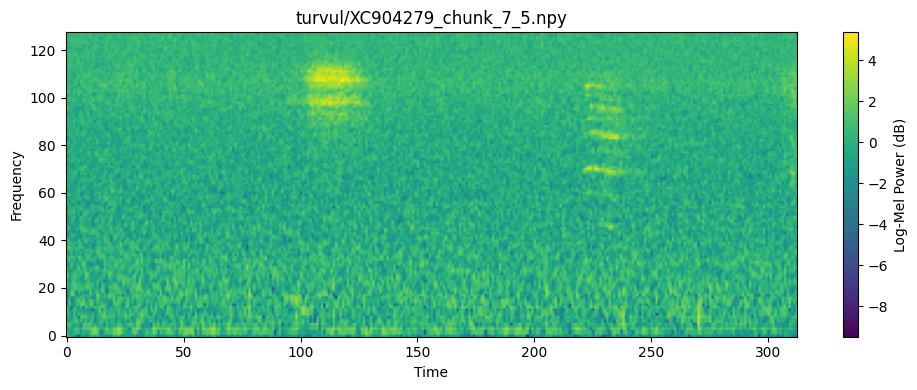

[INFO] Inspecting chunk: turvul/XC904279_chunk_15.npy
[INFO] Primary label: turvul
[INFO] Visualizing spectrogram: /kaggle/working/precomputed_spectrograms/turvul/XC904279_chunk_15.npy


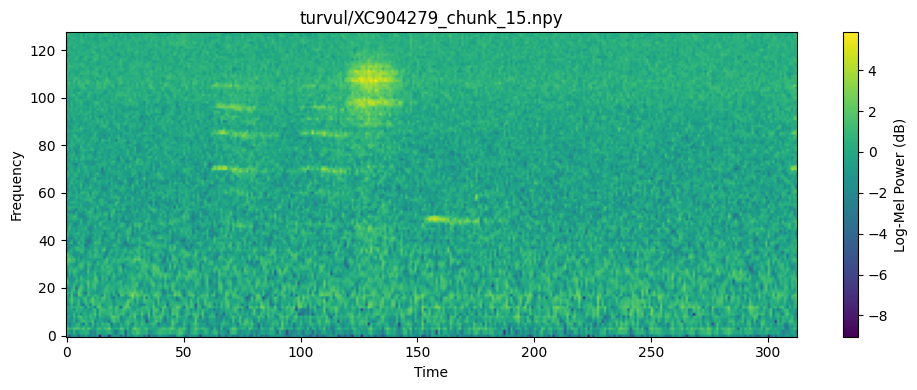

In [20]:
collection_sample_strategy = {
    "XC": sample_strategy_xc,
    "iNat": sample_strategy_inat,
    "CSA": sample_strategy_csa
}

def check_spectogram_given(primary_label, n=0):
    
    tracker = ChunkStatsTracker()
    sample = filter_data(train_df, primary_label=primary_label)
    fname, i = sample.iloc[n]["filename"], sample.index[n]
    play_audio(cfg.train_data_path, sample.iloc[n])
    preprocessor = SpectrogramPreprocessor(cfg, train_df, species_stats, model_predict_fn, tracker, collection_sample_strategy, num_workers=1)
    metadata = preprocessor.process_file(i, fname)
    
    # --- Run inspection ---
    print(f"[INFO] Total chunks processed: {len(metadata) if metadata is not None else 0}")
    if metadata:
        inspect_chunks(metadata, cfg.spectrogram_dir)

#check_spectogram_given("1139490", 1)
#check_spectogram_given("1192948", 3)
#check_spectogram_given("1194042", tracker, 1) #  1194042/CSA18783.ogg CSA18802?
#check_spectogram_given("126247") #iNat888527
#check_spectogram_given("1564122", 2) # CSA34198
#check_spectogram_given("21038", 1) # iNat65519
#check_spectogram_given("22333", 1) # iNat1005729
#check_spectogram_given("1462737", 2) # iNat1005729
#check_spectogram_given("1462711", 2) # iNat1005729
#check_spectogram_given("48124", 5) # iNat1005729
#check_spectogram_given("compau", 21) # iNat1005729
#check_spectogram_given("134933", 3) # iNat1005729 21211
check_spectogram_given("turvul", 5)

In [14]:
sample = filter_data(train_df, primary_label="turvul") # 41778
sample.head(20)

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
24131,turvul,[''],['wing beats'],turvul/XC115721.ogg,XC,1.0,https://xeno-canto.org/115721,-20.7900,-42.8882,Cathartes aura,Turkey Vulture,Noé Eiterer,cc-by-nc-sa 3.0
24132,turvul,[''],"['alarm call', 'call', 'hatchling or nestling']",turvul/XC520287.ogg,XC,4.0,https://xeno-canto.org/520287,-29.4120,-71.3572,Cathartes aura,Turkey Vulture,Cristian Pinto,cc-by-nc-sa 4.0
24133,turvul,[''],"['alarm call', 'call', 'hatchling or nestling']",turvul/XC520288.ogg,XC,5.0,https://xeno-canto.org/520288,-29.4120,-71.3572,Cathartes aura,Turkey Vulture,Cristian Pinto,cc-by-nc-sa 4.0
24134,turvul,[''],"['furnarius rufus', 'patagienas maculosa']",turvul/XC748979.ogg,XC,4.0,https://xeno-canto.org/748979,-31.8685,-58.2083,Cathartes aura,Turkey Vulture,Guillermo Treboux,cc-by-nc-sa 4.0
24135,turvul,[''],['wingbeats as flushing'],turvul/XC780516.ogg,XC,4.0,https://xeno-canto.org/780516,31.7880,-110.6390,Cathartes aura,Turkey Vulture,Richard E. Webster,cc-by-nc-sa 4.0
24136,turvul,[''],['hiss'],turvul/XC904279.ogg,XC,4.0,https://xeno-canto.org/904279,40.3224,-75.4128,Cathartes aura,Turkey Vulture,Brian Henderson,cc-by-nc-sa 4.0
24137,turvul,[''],[''],turvul/iNat1107301.ogg,iNat,0.0,https://static.inaturalist.org/sounds/1107301.wav,43.2780,-80.0123,Cathartes aura,Turkey Vulture,C Colangelo,cc-by 4.0
24138,turvul,[''],[''],turvul/iNat1275362.ogg,iNat,0.0,https://static.inaturalist.org/sounds/1275362.wav,27.8231,-80.7070,Cathartes aura,Turkey Vulture,Unknown,cc-by-nc 4.0
24139,turvul,[''],[''],turvul/iNat21647.ogg,iNat,0.0,https://static.inaturalist.org/sounds/21647.m4a,44.5581,-73.3048,Cathartes aura,Turkey Vulture,Alex Kulungian,cc-by-nc 4.0
24140,turvul,[''],[''],turvul/iNat272287.ogg,iNat,0.0,https://static.inaturalist.org/sounds/272287.m4a,43.2662,-81.0532,Cathartes aura,Turkey Vulture,Jazz (aka turtlehelper),cc-by-nc 4.0


In [ ]:
# Initialize preprocessor
tracker = ChunkStatsTracker()
preprocessor = SpectrogramPreprocessor(cfg, train_df, species_stats, model_predict_fn, tracker, collection_sample_strategy)

# Load training metadata
train_df = pd.read_csv(cfg.metadata_path)

# Get all filenames and ratings
all_files = [(idx, row.filename) for idx, row in train_df.iterrows() if row.filename.endswith(".ogg")]

# Start precomputation
print("[INFO] Starting spectrogram pre-computation...")
preprocessor.preprocess_all_files(all_files)
